In [2]:
import numpy as np
import pandas as pd
import os, sys
import utm
from scipy.io import savemat

# Import file (mostly for testing)

In [4]:
cwd = os.getcwd()

In [5]:
#replace with file name
directory_name = "/Lombardia Richiesta dati Manuela Girotto"
file_name = "/Dati quantitativi Bergamo_2002_2021"
original_file_type = ".xlsx"
#change last part depending on imported file type
file_path = cwd + directory_name + file_name + original_file_type

### Use this for files *with* labeled columns

<AxesSubplot:>

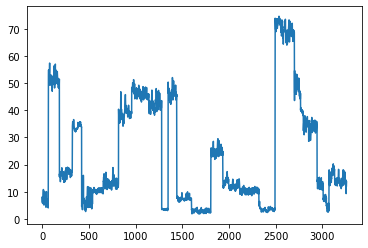

In [10]:
data = pd.read_excel(file_path)
#Uncomment to Display Table
data["MISURA SOGGIACENZA [m]"].plot()

### Use this for files *without* labeled columns

# Convert to Meters

In [44]:
def convert_to_meters(original_units, units_column_name, data):
    
    if original_units == "feet":
        data[units_column_name] = data[units_column_name] * 0.3048
        
    elif original_units == "kilometers":
        data[units_column_name] = data[units_column_name] * 0.001

# Consistent Reference Points

In [45]:
#Only found observations from sea-level (Ask about)

# Flag/Remove Errors

In [46]:
#Sift through at end to find if there are common errors throughout files
#if there are create a functio to remove, if not just manually remove

# Check for Natural Variability

In [47]:
col_id = "CODICE PUNTO"
col_ms = "MISURA SOGGIACENZA [m]"
variability_num = 1

def check_variability(col_ms, col_id, variability_num, data):
    data['Variability'] = abs(data[col_ms] - (data[col_ms].shift()))
    data['Variability'] = data['Variability'] > variability_num
    data['Changed_id'] = data[col_id] == data[col_id].shift()

    data['Final'] = data['Variability'] & data['Changed_id']
    data = data.drop(["Variability", "Changed_id"], axis = 1)
    data = data[data['Final'] == False]

# Too Few Observations

In [48]:
#Count of each unique 'CODICE PUNTO'
id_col = "CODICE PUNTO"
min_count_allowed = 70
def too_few_observations(min_count, id_col, data):
    flagged_id = []
    arr = data.value_counts(id_col)[data.value_counts(id_col) <= min_count_allowed].index
    arr = np.array(arr)
    np.set_printoptions(suppress=True)

    for index in data.index:
        if data[id_col][index] in arr:
            flagged_id = np.append(index, flagged_id)

    for x in flagged_id:
        data = data.drop(x, axis = 0)
        print(x)

In [49]:
# for i in data['CODICE PUNTO'].unique():
#     print(data[data['CODICE PUNTO'] == i])

# Export to Excel File type

In [50]:
cleaned_file_path = cwd + "/cleaned_data"

In [51]:
#creates directory if it doesn't already exist
if not (os.path.exists(cleaned_file_path)): 
    os.makedirs(cleaned_file_path)

In [52]:
data.to_excel(cwd + "/cleaned_data" + file_name + "_cleaned.xlsx", index = False)

# Function to perform functions on all files in directory

In [13]:
#This is the directory name may need to be the full file path 
#if errors persist due to 'No such file or directory' this will need 
#to be edited
directory_name = "/Lombardia Richiesta dati Manuela Girotto"
#Way to identify station
id_col = "CODICE PUNTO"
#Minimum number of observations
min_count_allowed = 1
#Column that holds the groundwater level values
col_ms = "MISURA SOGGIACENZA [m]"
#How different is it allowed to be from the previous observation? 
#Could also be a proportion but that would need to be implimented in the method
variability_num = 10
#What was the original unit of measurement
original_units = "meters" 
#What is the column that needs their units to be changed
units_column_name = "meters"
#Whether or not the unprocessed files are .xlsx or .csv
original_file_type = ".xlsx"
#Adding a new place for the processed data to export
cleaned_file_path = cwd + "/cleaned_data"

whole_table = pd.DataFrame()

#It will create a folder in the cleaned_file_path if it does not exists
if not (os.path.exists(cleaned_file_path)):
    os.makedirs(cleaned_file_path)
        

for files in os.listdir(cwd + directory_name):
    if files.endswith(original_file_type):
        
        if not (os.path.exists(cwd + "/processed_data/Lombardia_processed")): 
            os.makedirs(cwd + "/processed_data/Lombardia_processed")
        
        file_path = cwd + directory_name + "/" + files
        
        #if original file type is excel change to pd.read_excel
        #if original file type is csv change to pd.read_csv
        data = pd.read_excel(file_path)
        #data = pd.read_csv(file_path)
        
        #If you don't need function feel free to comment it out
        #check_variability(col_ms, col_id, variability_num, data)
        
        #too_few_observations(min_count_allowed, id_col, data)
        
        #Don't run this if you don't need it, or don't change first 2 variables
        #convert_to_meters("meters", "meters", data)
        
        whole_table = whole_table.append(data)
        
        export = data[[ 'CODICE PUNTO', 'DATA', 'MISURA SOGGIACENZA [m]']]
        
        #These are the columns you want to keep, change as needed
        #Will add rename function when I find out what columns are needed and how we want to display them
        
        #If you want an .xlsx file you can change data.to_excel
        #If you want a .csv file you can change to data.to_csv
        for i in export['CODICE PUNTO'].unique():
            hold = export[export['CODICE PUNTO'] == i]
            
            max_year = str(export[export['CODICE PUNTO'] == i]['DATA'].max())[:4]
            min_year = str(export[export['CODICE PUNTO'] == i]['DATA'].min())[:4]

            hold.to_excel(cwd + "/processed_data/Lombardia_processed/" + i + "_" + min_year
                          + "_" + max_year + ".xlsx", index = False)
            if not (os.path.exists(cwd + "/processed_data/Lombardia_Processed/mat_files/")): 
                os.makedirs(cwd + "/processed_data/Lombardia_processed/mat_files/")
            savemat(cwd + "/processed_data/Lombardia_processed/mat_files/" + str(i) + "_" +
                      min_year + "_" + 
                      max_year + ".mat", hold)
            

In [14]:
whole_table = whole_table[['CODICE PUNTO', 'DATA', 'MISURA SOGGIACENZA [m]']]
whole_table.to_excel(cwd + "/processed_data/Lombardia_processed/COMBINED_LOMBARDIA_TABLE.xlsx", index = False)

In [15]:
static_table = pd.DataFrame()

for i in whole_table['CODICE PUNTO'].unique():
    
    max_year = str(data[data['CODICE PUNTO'] == i]['DATA'].max())[:4]
    min_year = str(data[data['CODICE PUNTO'] == i]['DATA'].min())[:4]
    
    holder = data[data['CODICE PUNTO'] == i][['PROVINCIA', 'COMUNE', 'CODICE PUNTO', 'Qr[m s.l.m.]', 'FILTRI_N',
                   'FILTRI_TOP', 'FILTRI_BOTTOM', 'USO', 'GroundWater Body (GWB_2015)',
                   'DESCRIZIONE','X_WGS84','Y_WGS84']].head(1)
    
    holder['date_beginning'] = min_year
    holder['date_ending'] = max_year
    
    static_table = static_table.append(holder)

static_table['Latitude'] = utm.to_latlon(static_table['X_WGS84'], static_table['Y_WGS84'], 32, 'T')[0]
static_table['Longitude'] = utm.to_latlon(static_table['X_WGS84'], static_table['Y_WGS84'], 32, 'T')[1]
static_table = static_table.drop(["X_WGS84", "Y_WGS84"], axis = 1)
    

static_table.to_excel(cwd + "/processed_data/Lombardia_processed/STATIC_LOMBARDIA_TABLE.xlsx", index = False)

In [16]:
static_table

,PROVINCIA,COMUNE,CODICE PUNTO,Qr[m s.l.m.],FILTRI_N,FILTRI_TOP,FILTRI_BOTTOM,USO,GroundWater Body (GWB_2015),DESCRIZIONE,date_beginning,date_ending,Latitude,Longitude
0,CR,ANNICCO,PO0190030U0035,60.280,1,103.4,116.9,POTABILE,GWB ISI MPAMO,soggiacenza statica,2004,2021,45.244615,9.882081
120,CR,CASALMAGGIORE,PO0190210U0218,25.060,2,78.5,102.5,POTABILE,GWB ISI BPPO,soggiacenza statica,2004,2021,44.974490,10.442024
209,CR,CASTELVISCONTI,PO019027NRA001,65.200,1,2,18,IRRIGUO,GWB ISS MPAO,soggiacenza statica,2006,2020,45.291509,9.948778
380,CR,CINGIA DE' BOTTI,PO019031NU0313,32.420,2,154,175,POTABILE,GWB ISI BPPO,soggiacenza statica,2004,2021,45.085487,10.272853
469,CR,CORTE DE' FRATI,PO019033NRA001,48.010,1,1.5,15,IRRIGUO,GWB ISS MPAO,soggiacenza statica,2006,2021,45.207082,10.102293
658,CR,CREDERA RUBBIANO,PO0190340U0001,71.950,1,133,143,POTABILE,GWB ISI MPAMO,soggiacenza statica,2005,2021,45.305589,9.654900
774,CR,CREMA,PO0190350UA005,81.340,2,80,132,POTABILE,GWB ISI MPAMO,soggiacenza statica,2006,2021,45.378478,9.678846
835,CR,CREMA,PO019035NRA001,77.810,1,1,10,NON DEFINITO,GWB ISS MPAO,soggiacenza statica,2006,2021,45.357931,9.672152
1019,CR,CREMONA,PO0190360UA005,43.680,2,158,213,POTABILE,GWB ISI MPAMO,soggiacenza statica,2006,2021,45.136849,10.059719
1084,CR,CREMONA,PO019036NUA001,42.990,1,2,15,NON DEFINITO,GWB ISS MPAO,soggiacenza statica,2006,2021,45.135468,10.055306
